# Manipulating Layers of ARIA standard GUNW products

**Author**: Brett A. Buzzanga, David Bekaert - Jet Propulsion Laboratory

This notebook provides an overview of the functionality included in the **ariaExtract.py** program. Specifically, we give examples on how to extract data and meta-data layers from ARIA Geocoded UNWrapped interferogram (GUNW) products over a user defined area of interest. In addition, we provide an overview of the methodology applied to manipulate specific data and meta-data layers. In this notebook, we use GUNW products spanning the start of the 2018 Hawaii rifting event. 

In this notebook, we will demonstrate how to extract:
- Product bounding boxes
- Imaging geometry layers (i.e., azimuth angle, incidence angle, look angle, perpendicular baseline)
- Data layers (i.e., amplitude, coherence, unwrapped phase, and connected components)

We also provide examples on the various methods of defining a spatial area of interest:
- Union (in space and time) of all products 
- A bounding box defined as South North West East coordinates
- A bounding box in the form of a vector shapefile.

    
<div class="alert alert-warning">
Both the initial setup (<b>Prep A</b> section) and download of the data (<b>Prep B</b> section) should be run at the start of the notebook. All other sections (examples and applications) do not need to be run in order.
</div>

<div class="alert alert-danger">
<b>Potential Errors:</b> 
    
- GDAL uses "HDF5" driver instead of "netCDF/Network Common Data Format" on GUNW products. Verify GDAL version >= 3.
- ARIA-tools needs to be installed to run this notebook
</div>


<div class="alert alert-info">
    <b>Terminology:</b>
    
- *Acquisition*: An image acquired by the satellite for a given date and time.
- *Interferogram*: An unwrapped image containing the surface displacement accumulated between two acquisitions.
- *Frame*: Outline of a product ground footprint.
- *Along-track*: The direction along satellite flight path. 
    </div>
    

## Table of Contents:
<a id='example_TOC'></a>

[**Overview of the ariaExtract.py program**](#overview)

[**Methods used in the ariaExtract.py program**](#methods)
- [Extraction of layers without need for manipulation](#method_1)
- [Extraction of full resolution meta-data layers](#method_2)
- [Extraction of unwrapped phase (and connected components) layer](#method_3)

[**Examples of the ariaExtract.py program**](#examples)
- [Example 1. Extracting and viewing of the interferogram outline](#example_1)
- [Example 2. Extracting a layer by spatial subsetting](#example_2)
    - [Extract amplitude with default parameters (intersection)](#example_2_1)
    - [Extract coherence with Bounding Box (SNWE)](#example_2_2)
    - [Extract incidence angle with shape file](#example_2_3)
- [Example 3. Downloading a mask](#example_3)
- [Example 4. Downloading a DEM](#example_4)


[**Applications**](#applications)
- [Application 1. ENU conversion factors](#application_1)
- [Application 2. Computing displacement map](#application_2)

## Prep A. Initial setup of the notebook

Below we set-up the directory structure for this notebook exercise. In addition, we load the required modules into our python environment using the **`import`** command. We also explicitly enable exceptions for GDAL as this allows us to capture GDAL errors.

In [1]:
# option to control the use of pre-staged data; [False/True]
Use_Staged_Data = True

# ------------------------------------------------------------------------------------------- #
# no changed below needed:
import os, copy
import shutil
import subprocess
from osgeo import gdal, ogr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FormatStrFormatter, StrMethodFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

## Defining the home and data directories at the processing location
work_dir = os.path.abspath(os.getcwd())
tutorial_home_dir = os.path.abspath(os.getcwd())
print("Work directory: ", work_dir)
print("Tutorial directory: ", tutorial_home_dir)
    
# Enable GDAL/OGR exceptions
gdal.UseExceptions()

# Verifying if ARIA-tools is installed correctly
try:
    import ARIAtools.util.shp as shputil
except:
#     raise Exception('ARIA-tools is missing from your PYTHONPATH')
    pass
        
os.chdir(work_dir)

if Use_Staged_Data:
    # Download two files with tropo correction
    !wget --directory-prefix=products https://gunw-development-testing.s3.us-west-2.amazonaws.com/unavco_2024/S1-GUNW-A-R-124-tops-20180502_20180408-043026-00157W_00018N-PP-9909-v3_0_1.nc
    !wget --directory-prefix=products https://gunw-development-testing.s3.us-west-2.amazonaws.com/unavco_2024/S1-GUNW-A-R-124-tops-20180502_20180408-043052-00157W_00019N-PP-7296-v3_0_1.nc

    # # Check if a stage file from S3 already exist, if not try and download it
    # f = 'ariaExtract.zip'
    # if not os.path.isfile(f):
    #     print('\nAttempting to download staged data ... ')
    #     try:
    #         cmd = f'aws s3 cp --region us-east-1 --no-sign-request s3://asf-jupyter-data/aria-data/{f} {f}'
    #         subprocess.run(cmd, shell=True, check=True)
                
    #     except:
    #         cmd = f'wget --no-check-certificate --no-proxy http://asf-jupyter-data-west.s3.amazonaws.com/aria-data/{f} {f} -q --show-progress'
    #         subprocess.run(cmd, stdout=None, stderr=subprocess.PIPE, shell=True)


    # # verify if download was succesfull
    # if os.path.isfile(f):
    #     if os.path.exists('products'):

    #         shutil.rmtree('products')
    #     !unzip {f}
    #     print('S3 pre-staged data retrieval was successful')
    # else:
    #     print("Download outside openSarLabs is not supported.\nAs alternative please start from ARIA-tools with the commandline calls provided at the top of this notebook")          
else:
    print("Will not be using S3 pre-staged data")


Work directory:  /Users/rzinke/Documents/ARIAdev/ARIA-tools-docs/JupyterDocs/ariaExtract
Tutorial directory:  /Users/rzinke/Documents/ARIAdev/ARIA-tools-docs/JupyterDocs/ariaExtract
--2024-07-30 12:18:06--  https://gunw-development-testing.s3.us-west-2.amazonaws.com/unavco_2024/S1-GUNW-A-R-124-tops-20180502_20180408-043026-00157W_00018N-PP-9909-v3_0_1.nc
Resolving gunw-development-testing.s3.us-west-2.amazonaws.com (gunw-development-testing.s3.us-west-2.amazonaws.com)... 52.92.153.234, 52.92.234.218, 52.92.131.250, ...
Connecting to gunw-development-testing.s3.us-west-2.amazonaws.com (gunw-development-testing.s3.us-west-2.amazonaws.com)|52.92.153.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112725225 (108M) [binary/octet-stream]
Saving to: ‘products/S1-GUNW-A-R-124-tops-20180502_20180408-043026-00157W_00018N-PP-9909-v3_0_1.nc’

S1-GUNW-A-R-124-top 100%[===================>] 107.50M  15.7MB/s    in 7.1s    

2024-07-30 12:18:13 (15.2 MB/s) - ‘products/S1

GUNW products are hosted at the NASA ASF DAAC. Downloading them requires a NASA Earthdata URS user login and requires users to add “ARIA Product Search” to their URS approved applications.

These earthdata credentials are to be populated in your local **`.netrc`**, which may be generated by executing the next cell

In [2]:
# create .netrc if it does not exist    
if not os.path.exists(os.path.expanduser('~/.netrc')):
    print('NEEDED To Download ARIA GUNWs: \n Link to create account : https://urs.earthdata.nasa.gov/')
    earthdata_user = input('Please type your Earthdata username:')
    earthdata_user = str(earthdata_user)
    earthdata_password = input('Please type your Earthdata password:')
    earthdata_password = str(earthdata_password)
    os.system('echo machine urs.earthdata.nasa.gov login "{usern}" password "{passwd}" > ~/.netrc; chmod 600 ~/.netrc'.format( \
              usern = earthdata_user, passwd = earthdata_password))

DEMs are accessed/downloaded through OpenTopography. Downloading them requires an OpenTopography api key.

Follow instructions listed here to generate and access API key through OpenTopography:
https://opentopography.org/blog/introducing-api-keys-access-opentopography-global-datasets

Once the api key is acquired, your local **`.topoapi`** may be populated by executing the next cell

In [3]:
# create .topoapi if it does not exist    
if not os.path.exists(os.path.expanduser('~/.topoapi')):
    print('API key location: My Account > myOpenTopo Authorizations and API Key > Request API key')
    opentopography_api_key = input('Please type your OpenTopo API key:')
    opentopography_api_key = str(opentopography_api_key)
    os.system('echo "{api_key}" > ~/.topoapi; chmod 600 ~/.topoapi'.format(api_key = str(opentopography_api_key)))

Below we define a plotting function that will be used throughout the notebook for plotting GDAL compatible datasets on a map.

In [4]:
def plot_layer(path_layer, lay_type=None, cmap=None, **kwargs):
    """ 
        path_layer is a string to the GDAL compatible dataset to be plotted
    """
    
    if not lay_type: 
        lay_type = os.path.dirname(path_layer)
    title = [os.path.basename(lay_type)]
    
    ## get the lon lat bounds
    ds       = gdal.Open(path_layer, gdal.GA_ReadOnly)
    trans    = ds.GetGeoTransform()
    extent   = [trans[0], trans[0] + ds.RasterXSize * trans[1], trans[3] + ds.RasterYSize*trans[5], trans[3]]
    
    ## loading the data
    n_bands  = ds.RasterCount
    lst_arrs = []
    
    for band in range(n_bands):
        raster = ds.GetRasterBand(band+1)
        arr    = raster.ReadAsArray()
        try:
            NoData = raster.GetNoDataValue()
            arr = np.ma.masked_where((arr>1e20) |(arr==NoData),arr )
        except:
            print('Could not find a no-data value...')
            arr = np.ma.masked_where(arr>1e20,arr)
        
        lst_arrs.append(arr)

    ds = None
    if n_bands <= 4:
        nrows = 1; ncols = n_bands
    elif n_bands == 20:
        # troposphere
        nrows = 4; ncols = 5
    else:
        raise Exception('Number of bands currently unsupported')
        
    
    ## initializing a figure
    fig, axes = plt.subplots(figsize=(12,9), ncols=ncols, nrows=nrows, sharex='col', sharey='row')
    axes = axes if isinstance(axes, np.ndarray) else np.array(axes)
    axe  = axes.ravel() 
    cmap = copy.copy(plt.cm.Greys_r)
    cmap.set_under('black')
    
    ## definging the plotting options for differnt layer types
    # Amplitude:
    if lay_type.endswith('amplitude'): 
        # will fix the maximum amplitude bound
        vmin=None
        vmax = 2000 
    # Coherence:
    elif lay_type.endswith('coherence'): 
        # has fixed range between 0-1
        vmin=0
        vmax = 1
    # Incidence angle:
    elif lay_type.endswith('incidenceAngle'): 
        vmin=None
        vmax=None
    # water
    elif lay_type.startswith('water'):
        # no bounds needed will be a 0/1 mask; match mintpy
        arr = np.ma.getdata(lst_arrs[0])
        lst_arrs[0] = arr
        vmin=0
        vmax=1
        cmap='binary_r'
    # deformation or unwrapped phase
    elif lay_type.startswith('defo'): 
        # let the data drive the bounds
        vmin=None
        vmax=None
        # change colormap to a warm type
        cmap=plt.cm.coolwarm
    elif lay_type.startswith('terr') or lay_type.startswith('topo'): 
        # let the data drive the bounds
        vmin=None
        vmax=None
        # change colormap to a warm type
        cmap=plt.cm.terrain
    elif lay_type == 'ENU':
        vmin=None
        vmax=None
        title = ['East', 'North', 'Up']
        fig.subplots_adjust(wspace=0.5)


    else:
        # let the data drive the bounds
        vmin=None
        vmax=None
        # change colormap to a warm type
        cmap=plt.cm.coolwarm
        
    # plotting the data    
    for i, ax in enumerate(axe):
        im   = ax.imshow(lst_arrs[i], cmap=cmap, vmin=vmin, vmax=vmax, extent=extent,interpolation='nearest')
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='5%', pad=0.25)
        if lay_type == 'ENU':
            fig.colorbar(im, cax=cax, format=FuncFormatter(lambda x, y: '{:.3f}'.format(x)))
        elif lay_type.startswith('water'):
            fig.colorbar(im, cax=cax, ticks=[vmin, vmax])
        else:
            fig.colorbar(im, cax=cax)

        ax.set_title(title[i], fontsize=15)
        ax.grid(False)

    axe[0].set_ylabel('latitude', labelpad=15, fontsize=15)
    axe[int(np.floor(n_bands/2))].set_xlabel('longitude', labelpad=15, fontsize=15)

## Prep B: Download the data

We will use the Big Island of Hawaii as the study area for this tutorial. Specifically, we will look at an interferogram (spanning from 20180408 through 20180502) which encompasses the start of the 2018 rifting event. 

ARIA provides unwrapped interferograms as GUNW products. As the spatial extent of a product is roughly the size of a Sentinel-1 SLC frame (250km x 250km), it is likely that an interferogram over a given study area is composed of multiple adjacent GUNW frames or products. For example, for our study area we will use a Sentinel-1 interferogram generated on track 124, spanning from 20180408 through 20180502, which consists out of two GUNW products or frames.

<img src="support_docs/Hawaii_Shakemap.png" alt="region" width="500">
<blockquote><b>Fig. 1</b> Shakemap of earthquake that occurred on May 4, 2018 in the southeastern corner of the Hawaiian Big Island. </blockquote>

### ARIA GUNW products

The GUNW product is an InSAR surface displacement product derived from Sentinel-1 SAR data and packaged as netCDF4 files. GUNW products contain both data and meta-data layers such as the interferometric amplitude, filtered unwrapped phase, filtered coherence, connected components, perpendicular and parallel baselines, incidence, azimuth and look angles. A detailed overview of the ARIA GUNW product with respect to processing, formatting, sampling, and data layers can be found on the [ARIA website](https://aria.jpl.nasa.gov/products/standard-displacement-products.html).

### Download options

GUNW products are hosted at the ASF DAAC and can be downloaded from the [ARIA-products page](https://aria-products.jpl.nasa.gov) and as beta products from the [ASF DAAC data search page](https://search.asf.alaska.edu/#/). If you know the GUNW filename of the product, you can also build a download link by appending the GUNW filename to **https://<i></i>grfn.asf.alaska.edu<i></i>/door/download/** . 

Alternatively, you can use the **`ariaDownload.py`** program provided within the ARIA-tools package to download data using a command-line interface. This program wraps around the ASF DAAC API and allows for search sub-setting of GUNW products based on track number, geometry (ascending or descending), as well as spatial and temporal bounding boxes criteria. For a full description of the **`ariaDownload.py`** program, see the [ariaDownload Tutorial](https://github.com/aria-tools/ARIA-tools-docs/blob/master/JupyterDocs/ariaDownload/ariaDownload_tutorial.ipynb).

<div class="alert alert-warning">
<b>Potential download failure:</b> 
GUNW products are hosted at the NASA ASF DAAC. Downloading them requires a NASA Earthdata URS user login and requires users to add “ARIA Product Search” to their URS approved applications

<b>Login Credentials:</b>
Save your user-name and password to a `.netrc` file in your `$HOME` directory, or pass the combination explicitly using `ariaDownload.py --user <user> --pass <pass>`.


To create a .netrc file, pass your earthdata credentials by running through (<b>Prep A</b> section) above.

Below we will use the **`ariaDownload.py`** to download the all the GUNW products on track 124 (**`-t`** option) for the interferogram pair *20180408_20180502* (**`--ifg`** option) into a *products* folder (**`-w`** option).

In [5]:
if not Use_Staged_Data:
    !ariaDownload.py -t 124 -w products --ifg 20180408_20180502 --version '3_0_1' -v 

We can now have a look at the downloaded products:

In [6]:
!ls products

S1-GUNW-A-R-124-tops-20180502_20180408-043026-00157W_00018N-PP-9909-v3_0_1.nc
S1-GUNW-A-R-124-tops-20180502_20180408-043052-00157W_00019N-PP-7296-v3_0_1.nc


The product filename has two fields, **XXYYYN/S-XXYYYN/S**, that are respectively associated with the western edge of south and north most corner of the geocoded interferogram (see [aria-website](https://aria.jpl.nasa.gov/products/standard-displacement-products.html) for a complete overview of the filename convention). The latitude bounds are specified as 5-digit number with 3 significant digits. The `duplicated_products` directory contains products that are the same except for the version. The default is to keep the newest versions and store any others in `duplicated_products`. 

Based on the filename of the two products, can you confirm the products are overlapping?

## Overview of the ariaExtract.py program
<a id='overview'></a>

The **`ariaExtract.py`** program allows for easy extraction of data and meta-data layers from ARIA standard GUNW products. The program will automatically determine which GUNW products need to be stitched or cropped in order to generate a seamless interferogram. By default, interferograms will be cropped to bounds determined by the common intersection and bounding box (if specified). Running **`ariaExtract.py`** with the **`-h`** option will show the parameter options. 

Let us explore these options:

In [7]:
!ariaExtract.py -h

/opt/miniconda3/envs/ARIA-tools/bin/ariaExtract.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('ARIAtools==1.1.0')
usage: ariaExtract.py [-h] -f IMGFILE [-w WORKDIR] [-gp GACOS_PRODUCTS]
                      [-l LAYERS] [-tm TROPO_MODELS] [-d DEMFILE]
                      [-p PROJECTION] [-b BBOX] [-m MASK] [-at AMP_THRESH]
                      [-nt NUM_THREADS] [-of OUTPUTFORMAT] [-croptounion]
                      [-ml MULTILOOKING] [-rr] [-mo MINIMUMOVERLAP]
                      [--version VERSION] [--nc_version NC_VERSION] [-verbose]
                      [--log-level LOG_LEVEL]

Program to extract data and meta-data layers from ARIA standard GUNW products.
Program will handle cropping/stitching when needed. By default, the program
will crop all IFGs to bounds determined by the common intersection and bbox
(if specified)

options:
  -h, --help            show thi

### 1. Product files to be used (-f option)

At minimum, users need to specify the GUNW files they want to extract information from. This is controlled using the **`-f`** option. Multiple products can be specified by providing them as a comma separated string (e.g., **`-f`**` 'products/S1-GUNW-A-R-124-tops-20180502_20180408-043106-21658N_19755N-PP-0dd0-v2_0_1.nc,products/S1-GUNW-A-R-124-tops-20180502_20180408-043040-20161N_18088N-PP-6704-v2_0_1.nc'`), or using a wildcard (e.g., **`-f`**` 'products/S1*.nc'`).

### 2. Layers to be extracted (-l option)

By default, no layers are extracted aside from the bounding boxes of the products. Layer extraction is controlled using the **`-l`** option. Valid options are "unwrappedPhase", "coherence", "amplitude", "bPerpendicular", "bParallel", "incidenceAngle", "lookAngle", and "azimuthAngle". Multiple layers can be extracted at once by specifying them as a comma separated string (e.g., **`-l`**` 'azimuth,coherence'`). You can use the `'all'` keyword to extract all possible layers at once (e.g., **`-l`**` all`).

### 3. DEM (-d and -p options)

By specifying the **`-d`**` Download` option, users can download the Copernicus GLO-90 DEM on the fly. The DEM will be cropped over the interferogram extent (ground swath). A DEM is required for extracting the meta-data layer fields (e.g., "bPerpendicular", "bParallel", "incidenceAngle","lookAngle", and "azimuthAngle"). Alternatively, users can also specify the location to a custom GDAL-compatible DEM and control its projection by specifying it with the **`-p`** option. All the meta-data layers are stored within the GUNW product as 3D data cubes (longitude, latitude, height). The full-resolution meta-data layers are generated by intersecting these 3D data-cube with the DEM.

### 4. Mask (-m option)

By specifying the **`-m`**` Download` option, users can download a waterbody mask compiled from the Global Self-consistent, Hierarchical, High-resolution Geography Database (GSHHG) on the fly. The mask will be cropped over the interferogram extent (ground swath). A mask is useful for masking out broader waterbodies (e.g. oceans and major lakes) from your output layers. Alternatively, users can also specify the location to a custom GDAL-compatible mask and control its projection by specifying it with the **`-p`** option.

### 5. Cropping and spatial sub setting (-b and -croptounion options)

The **`ariaExtract.py`** program will automatically handle cropping and stitching of GUNW products when needed. By default, the program will crop all interferograms to bounds determined by the common intersection (of all interferograms) and the user-defined bounding box option. All layers are cropped and/or stitched using GDAL (see the [methods](#methods) section for details on the implemented approach for each layer). Below we discuss which options are available for specifying an area-of-interest.

#### Interferogram intersection versus union (-croptounion option)

GUNW products are grouped in clusters that belong to the same interferometric pair. By default, the spatial **intersection** of the interferometic pairs is used to define the region of interest. This can be overriden to be the union of all interferograms (regardless of alignment) by passing the **`--croptounion`** argument. A schematic example is shown in **Fig 2** for both scenarios.

<div class="alert alert-warning">
<b>Warning:</b> Users in general should avoid mixing products of adjacent satellite tracks (i.e., products made on the same contiguous pass are ok). Note that along the equator, the track number (ascending data on the ascending note) gets incremented while the data itself is still continuous.
</div>

<img src="support_docs/spatial_config_new.png" alt="spatial_configuration" width="700">
<blockquote> <center><b> Fig. 2 </b> Schematic of the spatiotemporal configuration for three interferograms. The left panel shows the intersection of the interferograms, which is the default behavior. The right panel shows the union of the interferograms, achieved by passing <b><code>--croptounion</code></b> . The blue dashed line demonstrates the behavior if the user had specified a bounding box (<b><code>-b</code></b>). Note that interferograms which do not cover the bounding box completely with the <b><code>--croptounion</code></b> or the <b><code>-b</code></b> option, will be padded with no-data values.</center></blockquote>

#### Bounding Box (-b option)

The user can specify a rectangular bounding box (South-North-West-East coordinates) as **`-b`**` 'S N W E'` or can provide a more complex area of interest using a shapefile or geoJSON as **`-b`**` path_to_file.shp`. A schematic example is shown in **Fig 3** for both scenarios.

<img src="./support_docs/crop.png" alt="cropping" width="700">
<blockquote><center><b> Fig. 3 </b> Schematic examples of the <b><code>-b</code></b> option available for cropping. The blue dashed line shows the user-specified area of interest. The left panel demonstrates the result when specifying SNWE coordinates, while the right panel shows the result when specifying a more complex polygon for the area of interest using a shapefile. </center></blockquote>

#### Minimum overlap option (-mo option)

For some cases (especially larger-scale studies spanning multiple frames), the region of interest defined by the common intersection of interferograms may lead to unanticipated results as relatively short interferograms (e.g. 1 frame long) may bias this reference region of interest such that most of the span of relatively longer interferograms (e.g. 3 frames) are masked out in the extracted layers.

Thus, we recommend leveraging the minimum overlap option (```-mo```) in order to control this behavior. The ```-mo``` option specifically can be used to reject those interferograms for which the intersection with the reference cutline does not meet a minimum area overlap (in $\mathrm{km^{2}}$) as set by the user. By default ```-mo``` = 0.0081 = 0.0081 $\mathrm{km^{2}}$, which represents the area of single pixel at standard 90m resolution. While trial-and-error may be involved, generally an easy way to reject shorter interograms would be to pass the area of a predefined user-bounding box as an argument.

For example, let’s suppose the area of the bounding box presented here is 1000 $\mathrm{km^{2}}$. The 2nd interferogram would be kicked out if ```-mo 1000``` were specified as it would fail to overlap completely with the bounding box:

<img src="./support_docs/minimumoverlap_example.png" alt="cropping" width="700">
<blockquote><center><b> Fig. 4 </b> Schematic examples of the <b><code>-mo</code></b> option available for enforcing minimum spatial overlap with respect to an area of interest. The blue dashed line shows the user-specified area of interest. The left panel demonstrates the default result where all interferograms with a minimum overlap with the area of interest of 0.0081 $\mathrm{km^{2}}$ (or one pixel) are passed, while the right panel shows the result when specifying a more conservative minimum overlap area. </center></blockquote>

### 6. Workdirectory (-w option)

The output of the **`ariaExtract.py`** program is saved within the working directory (**`-w`**), which by default is the current directory. Within the work directory the outputs are organized in separate subdirectories, where the sub-directory name corresponds to the layer being extracted. Within each subdirectory, the data and meta-data are saved with the interferogram pair dates "date1_date2" serving as the basename.

### 7.  Output format (-o option)

The **`ariaExtract.py`** program leverages GDAL for file reading and writing of outputs. The user can therefore specify any GDAL compatible format (e.g., ENVI, ISCE, GTiff; see GDAL for more information on [supported formats](https://gdal.org/drivers/raster/index.html)) for saving the outputs from **`ariaExtract.py`**.  By default, "unwrappedPhase", "bPerpendicular", "bParallel", "incidenceAngle", "lookAngle", and "azimuthAngle" are stored as ENVI files, as these layers required  mathematical manipulation. Other layers including "coherence" and "amplitude" do not require this, and by default are stored as virtual files (.vrt) to conserve disk space.

## Methods used in the ariaExtract.py program
<a id='methods'></a>

The **`ariaExtract.py`** program will automatically handle the stitching and cropping of layers based on a user area of interest, and the union or intersection of all interferograms. The start and stop product sensing times contained within each GUNW product is used to figure out which GUNW products form a single, contiguous interferogram. As all GUNW products are provided on an uniform grid (in sampling and origin), there is no need for resampling. 

The method used for stitching the data and meta-data layers for a given interferogram varies depending on the layer. Three main variants exist:
1. Extraction of layers without need for manipulation (amplitude and coherence).
2. Extraction of full resolution meta-data layers (bPerpendicular, bParallel, incidenceAngle, lookAngle, and azimuthAngle).
3. Extraction of unwrapped phase (and connected component) layer.

Below we elaborate on each of these variants.

### 1.  Extraction of layers without need for manipulation
<a id='method_1'></a>

The *amplitude* and *coherence* layers are stitched together using a mosaicking approach leveraging GDAL **`gdalwarp`** functionality. The stitched layer data in the product overlap region is constrained by one of the two overlapping products without loss of information.

### 2. Extraction of full resolution meta-data layers
<a id='method_2'></a>

The imaging geometry meta-data layers such as *bPerpendicular, bParallel, incidenceAngle, lookAngle,* and *azimuthAngle* are provided within each GUNW product as 3D-data cubes. Since the imaging geometry meta-data layers vary smoothly in space, they are specified with sparse lateral (0.1 arcsec) sampling on fixed height levels (-1.5, 0, 3 and 9 km) for data reduction purposes. 

The full resolution meta-data layer is retrieved by intersecting the 3D data-cube with a DEM (see **Fig. 4**). Users can either provide a custom DEM or specify the DEM download option to retrieve and use the Copernicus GLO-90 DEM. The DEM is interpolated (nearest neighbor) to the native grid of the interferogram. Prior to the intersection of the DEM with the 3D dataset, we mosaic the 3D-data cubes of the different GUNW products together for each interferogram. The intersection itself is done by performing a bivariate spline interpolation laterally and a cubic interpolation vertically to calculate the values at the DEM grid nodes.

<img src="support_docs/interp_2d.png" alt="interp_sketch" width="600" >
    <blockquote> <b>Fig. 4</b> Schematic example of the 3D meta-data cube and intersection routine with a DEM to retrieve the full resolution meta-data layer. Not drawn to scale.</blockquote>

#### Correction layers:
There are three optional layers intended to mitigate unwanted phase delays. These correction layers rely on additional algorithms, and the layers themselves are encoded as 3D data cubes similar to the geometry meta-data layers.

The correction layers are:
* **Troposphere correction** &ndash; Tropospheric propagation delays are one of the largest bottlenecks that limit the retrieval accuracy of ground displacement using InSAR. For example, surface displacements of small magnitude (e.g. interseismic deformation, transients) or those that are correlated with topography (e.g. volcano deformation) are often masked by the tropospheric noise (e.g., [Hooper et al., 2012](https://www.sciencedirect.com/science/article/pii/S0040195111004343); [Bekaert et al, (2015)](https://www.sciencedirect.com/science/article/pii/S0034425715301231)). For ARIA products, optional tropospheric corrections are estimated from weather model outputs such as [ECMWF](https://www.ecmwf.int/), NASA [GMAO](https://gmao.gsfc.nasa.gov/), NOAA [HRRR](https://rapidrefresh.noaa.gov/hrrr/), etc. The troposphere corrections are implemented through the [RAiDER](https://github.com/dbekaert/RAiDER) open-source software, which uses a ray-tracing approach to directly obtain slant-delay.
* **Solid Earth tide correction** &ndash; The solid Earth flexes in response to the lunar and solar gravitational forces that drive ocean tides. This flexure can reach 20&ndash;30 cm in amplitude (e.g., [Milbert, 2018](https://geodesyworld.github.io/SOFTS/solid.htm)). The solid Earth tide (SET) can be estimated to an accuracy within 1 mm based on spherical harmonics ([IERS Conventions, 2003, Section 7.1.2](https://www.iers.org/IERS/EN/Publications/TechnicalNotes/tn32.html)). These calculations are implemented using [PySolid](https://github.com/insarlab/PySolid) ([Yunjun et al., 2022](https://ieeexplore.ieee.org/document/9759304)), a Python wrapper for the *[solid](https://geodesyworld.github.io/SOFTS/solid.htm#link3)* program (Milbert, 2018). ARIA products optionally provide layers to correct for these effects.
* **Ionosphere correction** &ndash; The ionosphere layers mitigate phase delays induced by the ionosphere ([Fattahi et al., 2017](https://ieeexplore.ieee.org/abstract/document/7987747)). The ionospheric phase screen is computed using the "split range-spectrum" approach of *Fattahi et al. (2017)*, whereby the spectrum of the radar signal in range is divided into two sub-bands with different center frequencies. Two sub-band interferograms are computed from the sub-band images of different acquisitions, representing the dispersive and non-dispersive components of the interferometric phase. The ionospheric phase delay is represented by the dispersive component, and can be removed from the signal. ***Please note:*** The ionospheric delay is difficult to estimate for C-band radar systems such as Sentinel-1, and is showcased here as an example for users to get accustomed to what will be included in the upcoming NISAR (L-band) data.

### 3. Extraction of unwrapped phase (and connected components) layer
<a id='method_3'></a>

An interferogram is  generated through the complex multiplication of the reference SLC with the complex conjugate of the secondary SLC, and thus is a wrapped image between $-\pi$ and $\pi$. As part of the unwrapping procedure, a continuous surface is created from the wrapped data by adding integer multiples of 2$\pi$ to its pixels. Unwrapping is not a trivial process, and is complicated by (decorrelation) noise in data. As part of the processing routine, a slant range pixel offset correction is estimated from the data, leading to a planar phase correction of small slope in the range direction (perpendicular to the satellite flight direction).

Since each GUNW product is processed and unwrapped separately, we need to account for an integer multiple of 2$\pi$ between GUNW products, and also correct for an additional bias introduced by range offset differences applied to each GUNW product. Both corrections are estimated from product overlap regions, after which we stitch products leveraging GDAL. We maintain the qualitative function of the connected component layer by adjusting each GUNW product connected component layer, while merging all the connected component 0s together.

<img src="support_docs/2frame_overlap.png" alt="overlap" width="30%" >
   <center> <b>Fig. 5</b> Schematic showing overlap region (shaded in red) used to estimate both a phase bias and integer multiple of 2$\pi$ correction between two GUNW products forming a single interferogram (blue and green outline, respectively). </center>

## Examples of the ariaExtract.py program<a id='examples'></a>

### Example 1. Extracting and viewing of the interferogram outline <a id='example_1'></a>

[Back to Example Table of Contents](#example_TOC)

The **`ariaExtract.py`** program groups GUNW products into spatially-temporally continuous interferograms. Even without extracting any layers, **`ariaExtract.py`** will create geoJSON files outlining the spatial extent for each interferogram. Below we demonstrate this on the two coseismic GUNW products using default parameters for the spatial sub-setting. 

In [8]:
!ariaExtract.py -f "products/*.nc"

/opt/miniconda3/envs/ARIA-tools/bin/ariaExtract.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('ARIAtools==1.1.0')


Within the *productBoundingBox* subdirectory, the outline for each stitched interferogram is saved as a geoJSON file using the acquisition dates to form the filename (e.g. '20180502_20180408.json'). 

In addition, a final bounding box 'productBoundingBox.json' is stored which details the spatial extent to which all interferograms will be cropped. By default, the *intersection* of the interferograms is used to determine the spatial extent. In our example, only one interferogram is considered without specifying additional options to subset in space (such as the **`--bbox`** option) so both files are identical.

In [9]:
!ls productBoundingBox

20180502_20180408.json
productBoundingBox.json
productBoundingBox_croptounion_formetadatalyr.json


We will view the outline saved in the geoJSON file, with the **`plot_shapefile`** function within **`shapefile_utils.py`** distributed with the ARIA-tools package. Note this is not a true ESRI shapefile, but can easily be converted to one using the `ogr2ogr` program (see [Application 3](#application3)).

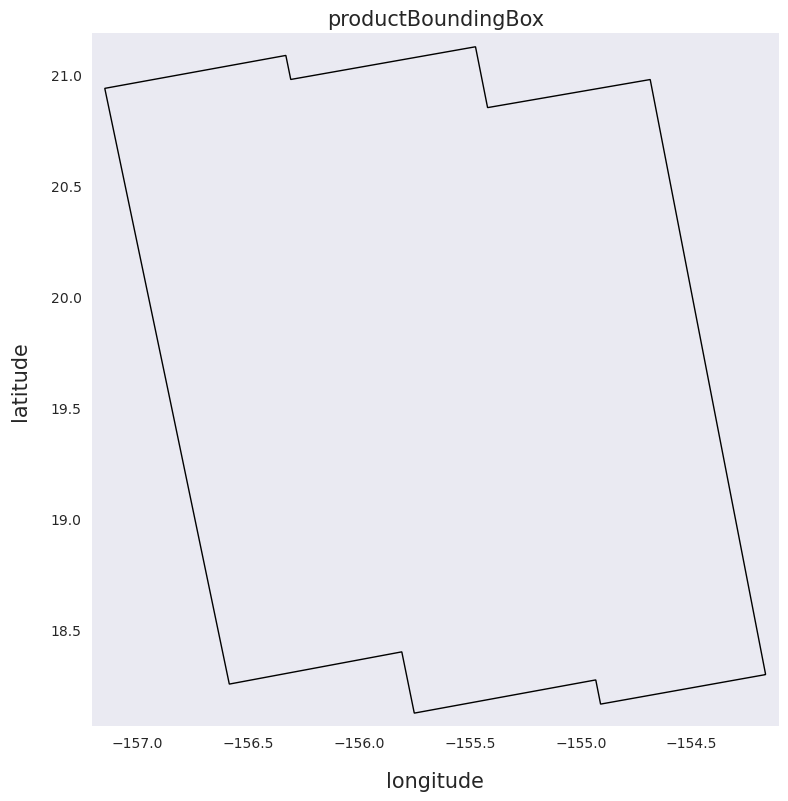

In [10]:
shputil.plot_shp(os.path.join('productBoundingBox', 'productBoundingBox.json'))

### Example 2. Extracting a layer by spatial subsetting
<a id='example_2'></a>

[Back to Example Table of Contents](#example_TOC)

Layers are extracted to separate subdirectories named after the 'layer name' under the specified working directory (`-w`), e.g. 'amplitude'. Within the layer subdirectories, the data and meta-data are saved with a given interferometric date combination serving as the filename, e.g. 'amplitude/20180502_20180408'. Any existing layers will be overwritten. Below, examples are provided by spatial subsetting using default parameters (intersection), bounding box, and shapefile.

#### 1. Extract amplitude with default parameters (intersection)
<a id='example_2_1'></a>

Below we will extract the *amplitude* layer using default parameters (intersection of common area to all interferograms).

In [11]:
!ariaExtract.py -f "products/*.nc" -l amplitude 

/opt/miniconda3/envs/ARIA-tools/bin/ariaExtract.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('ARIAtools==1.1.0')


The extracted amplitude layer is stored within the *amplitude* folder and with the interferometric date combination as its filename. Note that amplitude is one of the layers which is stitched *virtually* by default. The *20180502_20180408_uncropped.vrt* is the complete stitched variant, while the other *20180502_20180408.vrt* file contains the amplitude layer as cropped over the `productBoundingBox.json` (see [example 1](#example_1) for details).

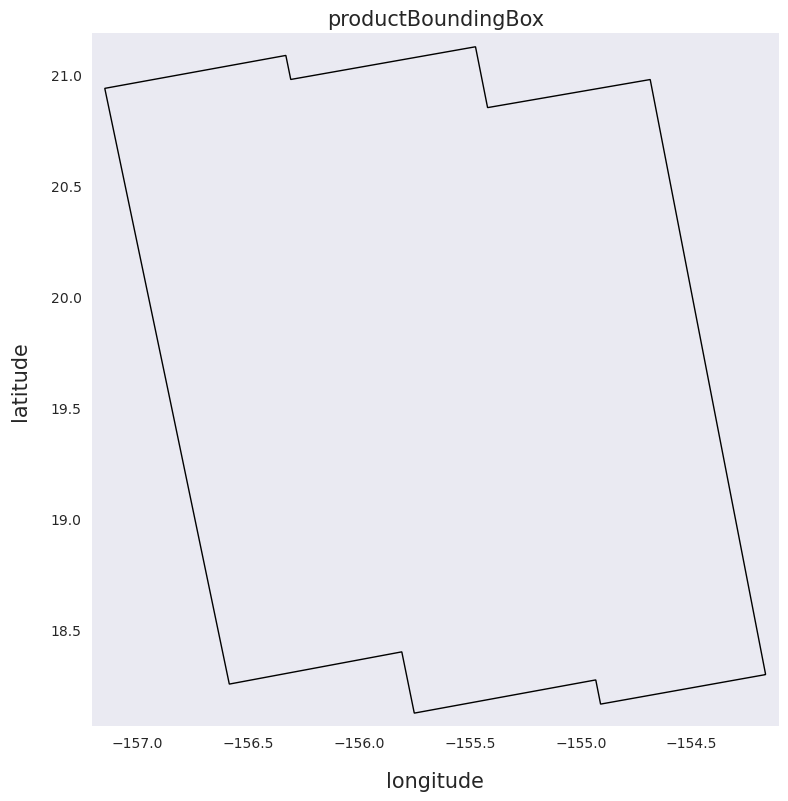

In [12]:
shputil.plot_shp(os.path.join('productBoundingBox', 'productBoundingBox.json'))

In [13]:
!ls amplitude

20180502_20180408.vrt           20180502_20180408_uncropped.vrt


We can now use our earlier defined plotting function to visualize the amplitude of the stitched interferogram.

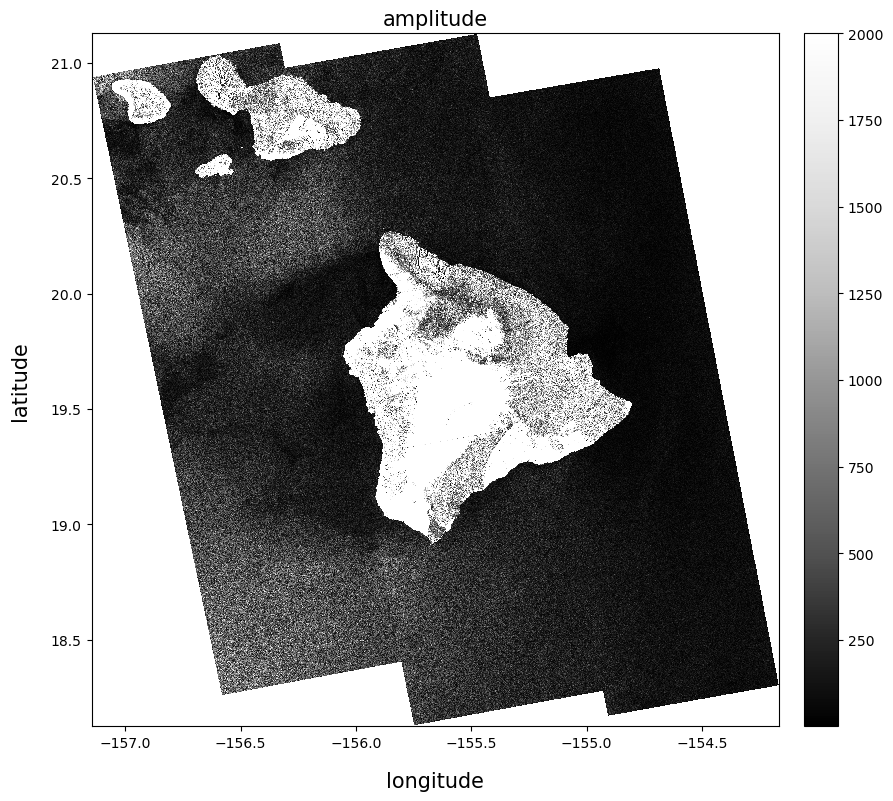

In [14]:
plot_layer(os.path.join('amplitude', '20180502_20180408.vrt'))

The amplitude corresponds to the complex magnitude of the interferogram. Darker colors indicate weaker backscatter of the radar signal, which depend on the characteristics of the surface. In rough water the amplitude will be brighter than in calm sea, as waves will be scattering part of the energy back. Over land, vegetated areas will appear darker compared to urban and mountain outcrops.

#### 2. Extract coherence with Bounding Box (SNWE)
<a id='example_2_2'></a>

Users can specify an area of interest as `SNWE` coordinates using the **`--bbox`** option. Coordinates should be specified as a space delimited string surround by quotes. The example below extracts the coherence over the main island of Hawaii.

In [15]:
!ariaExtract.py -f "products/*.nc" -l coherence --bbox "18.8 20.3 -156.1 -154.8"

/opt/miniconda3/envs/ARIA-tools/bin/ariaExtract.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('ARIAtools==1.1.0')


The extracted coherence layer is stored within the *coherence* folder and with the interferometric date combination as its filename. As with the amplitude layer, coherence is one of the layers which is stitched *virtually* by default. The *20180502_20180408_uncropped.vrt* is the complete stitched variant, while the other *20180502_20180408.vrt* file contains the coherence layer as cropped over the *productBoundingBox.json*, which is now cropped to the specified SNWE coordinates (see [example 1](#example_1) for details on the *productBoundingBox*).

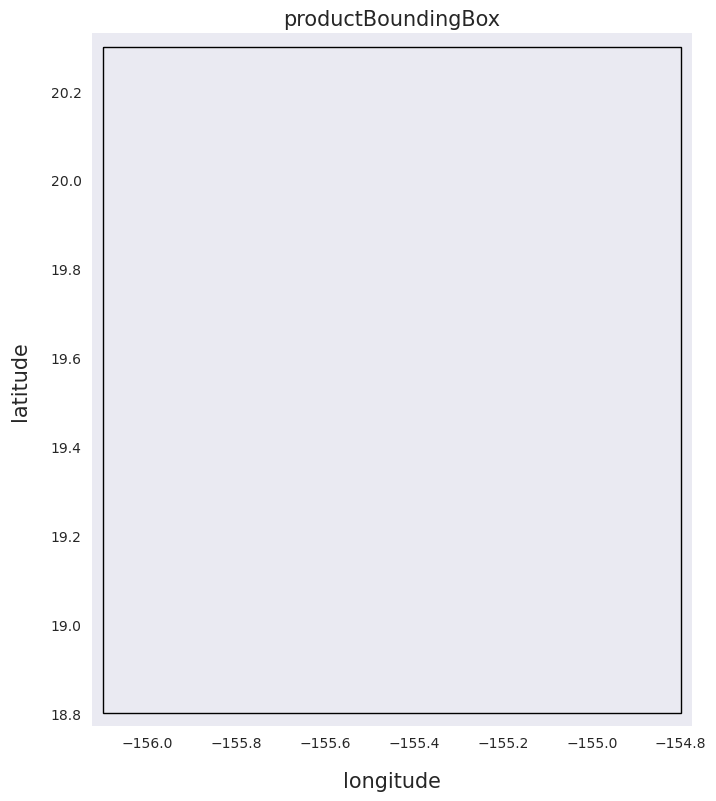

In [16]:
shputil.plot_shp(os.path.join('productBoundingBox', 'productBoundingBox.json'))

In [17]:
!ls coherence

20180502_20180408.vrt           20180502_20180408_uncropped.vrt


The spatial extent of the coherence file can be confirmed by running **`gdalinfo`** on the vrt of the coherence layer.

In [18]:
!gdalinfo coherence/20180502_20180408.vrt -stats

Driver: VRT/Virtual Raster
Files: coherence/20180502_20180408.vrt
       coherence/20180502_20180408_uncropped.vrt
Size is 1561, 1801
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-156.100770892999321,20.300825213000003)
Pixel Size = (0.000833333000000,-0.000833333000000)
Corner Coordinates:
Upper Left  (-156.1007709,  20.3008252) (156d 6' 2.78"W, 20d18' 2.97"N)
Lower Left  (-156.1007709,  18.7999925) (156d 6' 2.78"W, 18d47'59.97"N)
Upper Right (-154.7999381,  20.30082

Alternatively, the coherence layer can be visualized to show the spatial extent as well.

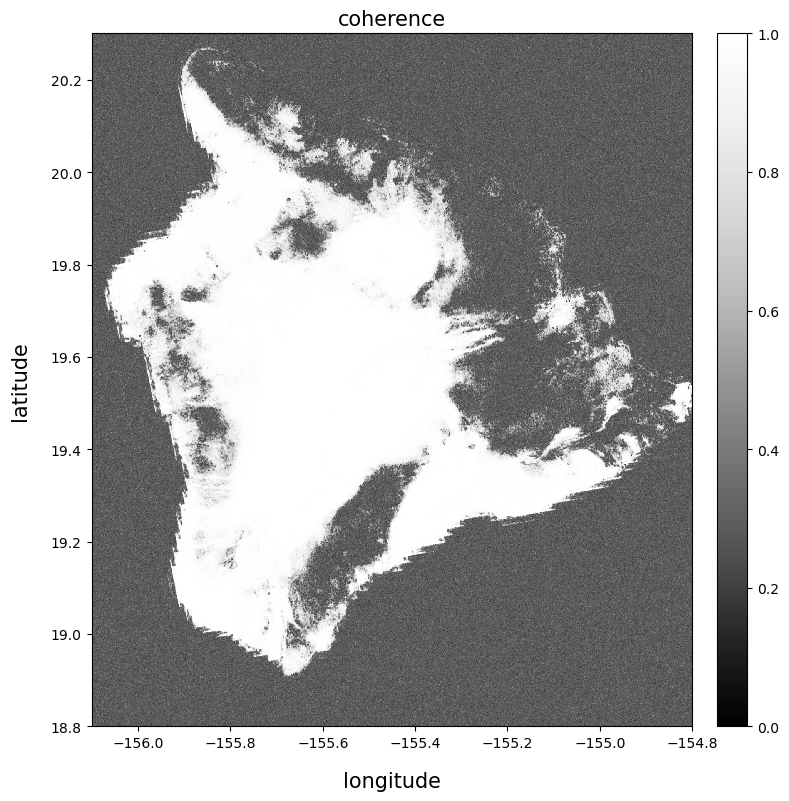

In [19]:
plot_layer(os.path.join('coherence', '20180502_20180408.vrt'))

The coherence is a qualitative marker for the interferogram, ranging between 0 and 1. 
Changes in the acquisition geometry and scattering (e.g. vegetation) lead to decorrelation. The higher the decorrelation, the lower the coherence, as can be observed over the vegetated regions of Hawaii. Coherence is computed using a 5 x 5 window on multi-looked data (~90 m resolution), and therefore its spatial resolution is rather on the order of 450 m. The coarseness of the estimation window can clearly be observed along the water-land boundary.  

#### 3. Extract incidenceAngle with shapefile
<a id='example_2_3'></a>

[Back to Example Table of Contents](#example_TOC)

Users can specify an area of interest using a shapefile through the **`--bbox`** option. The shapefile should be saved as a polygon geometry, compatible with GDAL, and with **WGS84** as reference. Here, we use a shapefile containing the Big Island of Hawaii, created from the [OpenStreetMap dataset](https://www.openstreetmap.org/) using the [OSMnx](https://geoffboeing.com/publications/osmnx-complex-street-networks/) python library. We will use GDAL's **`orginfo `** to verify its contents:

In [20]:
shp = os.path.join(tutorial_home_dir, 'support_docs', 'Big_Island', 'Big_Island.shp')
!ogrinfo -so {shp} Big_Island

INFO: Open of `/Users/rzinke/Documents/ARIAdev/ARIA-tools-docs/JupyterDocs/ariaExtract/support_docs/Big_Island/Big_Island.shp'
      using driver `ESRI Shapefile' successful.

Layer name: Big_Island
Metadata:
  DBF_DATE_LAST_UPDATE=2019-05-09
Geometry: Polygon
Feature Count: 1
Extent: (-156.061881, 18.910620) - (-154.806698, 20.268474)
Layer SRS WKT:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["latitude",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["longitude",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
bbox_east: String (80.0)
bbox_north: String (80.0)
bbox_south: String (80.0)
bbox_west: String (80.0)
place_name: String (108.0)


Below we extract the *incidenceAngle* layer using this shapefile, which outlines the entire island. Since this is a geometry meta-data layer, a DEM needs to be provided using the **`-d `** option. Note, in case you already have downloaded a DEM, you could now update and specify the path to the DEM file directly, e.g., **`-d `**`DEM/glo_90.dem`.

In [21]:
print('ariaExtract.py -f "products/*.nc" -l incidenceAngle -d Download -b {}'.format(shp))
!ariaExtract.py -f "products/*.nc" -l incidenceAngle -d Download -b {shp} 

ariaExtract.py -f "products/*.nc" -l incidenceAngle -d Download -b /Users/rzinke/Documents/ARIAdev/ARIA-tools-docs/JupyterDocs/ariaExtract/support_docs/Big_Island/Big_Island.shp
/opt/miniconda3/envs/ARIA-tools/bin/ariaExtract.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('ARIAtools==1.1.0')
2024-07-30 12:32:52,910 - ARIAtools.util.dem - WARNING - Cannot proceed with VRT format, using ENVI format instead


The extracted incidence angle is stored within the *incidenceAngle* folder and with the interferometric date combination as its filename. Unlike coherence and amplitude, the meta-data layers are physically written out as *ENVI* files, and cropped to the *productBoundingBox.json*, which is now cropped to the specified shapefile (see [example 1](#example_1) for details on the *productBoundingBox*). The output format can be controlled using the **`-of`** option.

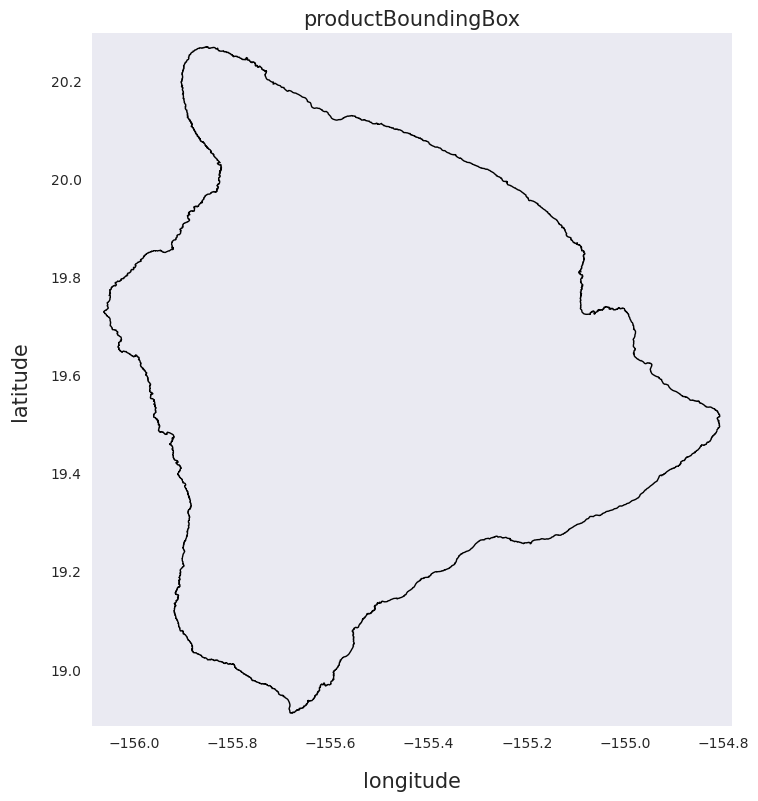

In [22]:
shputil.plot_shp(os.path.join('productBoundingBox', 'productBoundingBox.json'))

In [23]:
!ls incidenceAngle/*

incidenceAngle/20180502_20180408
incidenceAngle/20180502_20180408.aux.xml
incidenceAngle/20180502_20180408.hdr
incidenceAngle/20180502_20180408.vrt


The spatial extent of the incidence angle file, as well as the no-data value, can be retrieved using **`gdalinfo`** on the vrt of the incidence angle file.

In [24]:
!gdalinfo incidenceAngle/20180502_20180408.vrt -stats

Driver: VRT/Virtual Raster
Files: incidenceAngle/20180502_20180408.vrt
       incidenceAngle/20180502_20180408
Size is 1507, 1631
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-156.062437574998995,20.269158559000001)
Pixel Size = (0.000833333000000,-0.000833333000000)
Metadata:
  Band_1=Band 1
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-156.0624376,  20.2691586) (156d 3'44.78"W, 20d16' 8.97"N)
Lower Left  (-156.0624376,  18.9099924) (1

Below we will visualize the incidence angle as extracted over the main island.

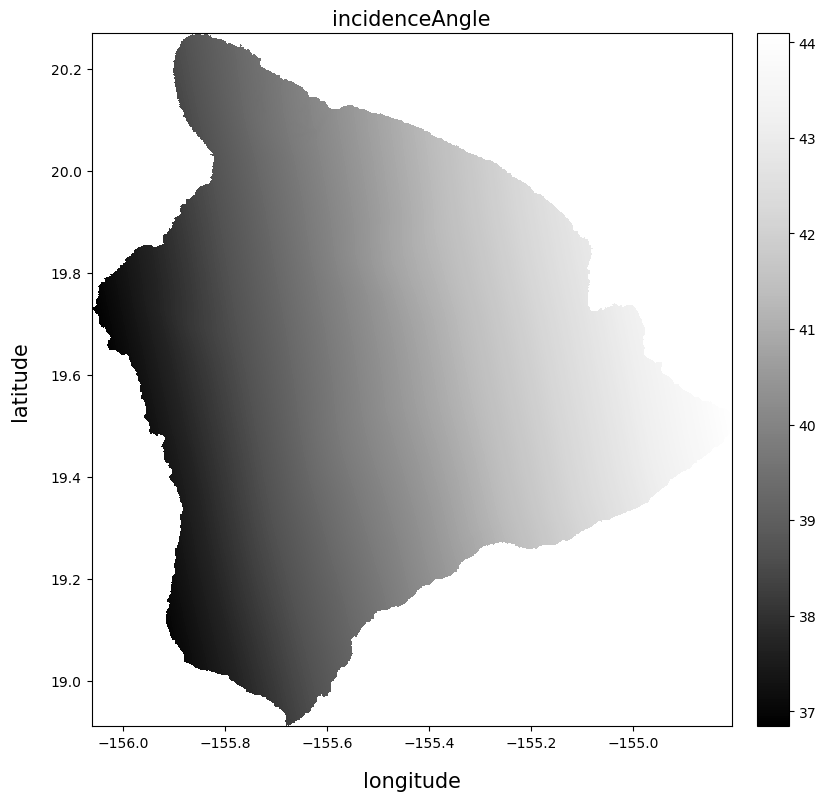

In [25]:
plot_layer(os.path.join('incidenceAngle', '20180502_20180408.vrt'))

The incidence angle is reported in degrees and corresponds to the angle between the vertical from the ground and the incomming radar raypath. As can be observed from the figure, anything outside the outline of the island (as delineated by the input shapefile 'data/Big_Island/Big_Island.shp') has been cropped out.

### Example 3. Downloading a mask
<a id='example_3'></a>

[Back to Example Table of Contents](#example_TOC)

To download a waterbody mask compiled from GSHHG, specify the **`-m Download`** option. By default, outputs are written to the local directory, which can be changed to another location by specifying the path with the **`-w`** option. The mask will be used to mask all extracted layers. Running the following command to completion will take ~3 mins, so it will be a great time to take a coffee/twitter break:

In [26]:
!ariaExtract.py -f "products/*.nc" -m download -b {shp}

/opt/miniconda3/envs/ARIA-tools/bin/ariaExtract.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('ARIAtools==1.1.0')
Reading tile imagery: 100%|███████████████████████| 2/2 [00:02<00:00,  1.27s/it]


The mask is cropped to the common interferometric grid, stored under local subdirectory *mask*, and given the filename *watermask.msk* (i.e. nested as *mask/watermask.msk*). Note that for consistency, if a user specifies a path to a custom mask, the cropped version is still stored under the local subdirectory *mask* and shares the same filename as the input.

Execute the next cell to visualize the mask. Broader waterbodies (e.g. oceans and major lakes) are delineated in the mask.

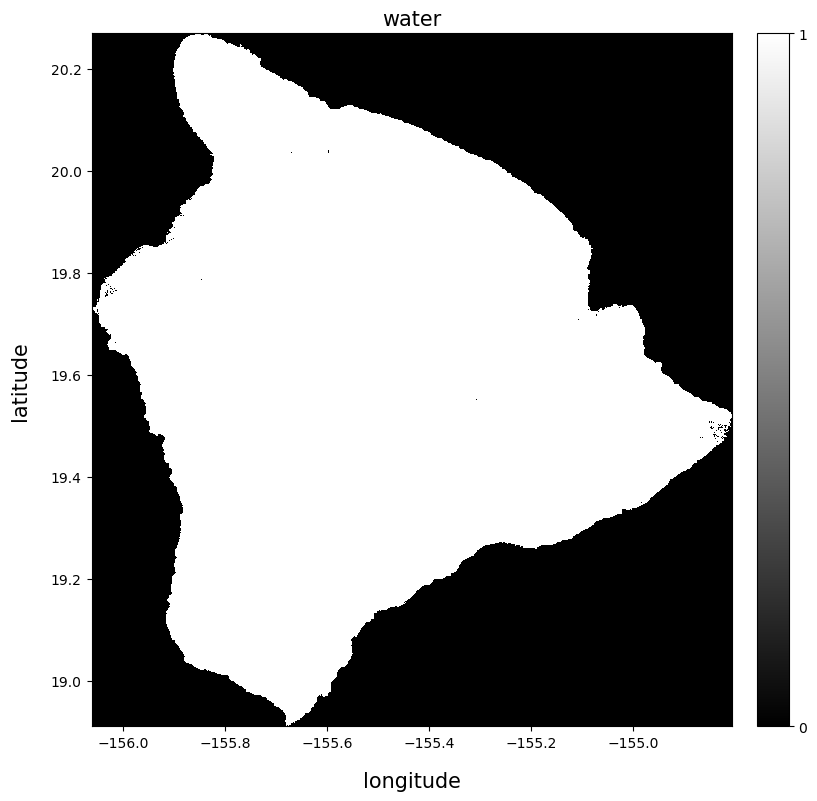

In [27]:
plot_layer('mask/esa_world_cover_2021.msk',lay_type='water')

Below we will apply this mask to the unwrapped phase layer.

/opt/miniconda3/envs/ARIA-tools/bin/ariaExtract.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('ARIAtools==1.1.0')


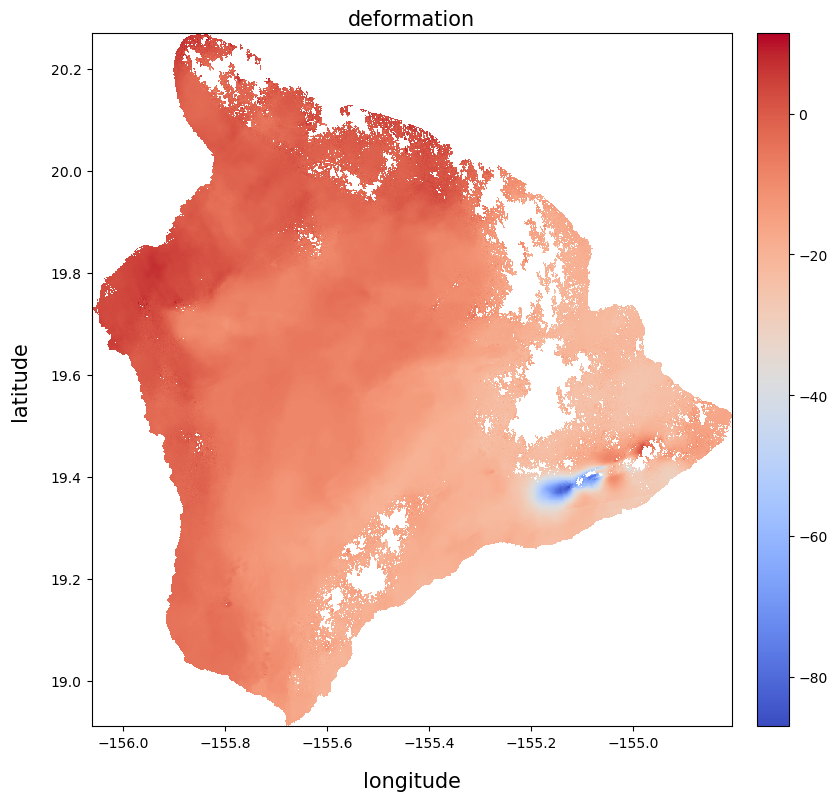

In [28]:
# extract masked unwrapped phase layer
!ariaExtract.py -f "products/*.nc" -l unwrappedPhase -m mask/esa_world_cover_2021.msk -b {shp}

## view the plot
plot_layer('unwrappedPhase/20180502_20180408', 'deformation')

### Example 4. Downloading a DEM
<a id='example_4'></a>

[Back to Example Table of Contents](#example_TOC)

To download a Copernicus GLO-90 DEM specify the **`-d Download`** option. By default outputs are written to the local directory, which can be changed to another location by specifying the path with the **`-w`** option. The DEM will be needed for the extraction of the full resolution meta-data layers.

Users can specify an area of interest using a shapefile through the **`--bbox`** option. The shapefile should be saved as a polygon geometry, compatible with GDAL, and with **WGS84** as reference. Here, we use a shapefile containing the Big Island of Hawaii, created from the [OpenStreetMap dataset](https://www.openstreetmap.org/) using the [OSMnx](https://geoffboeing.com/publications/osmnx-complex-street-networks/) python library. This shapefile will clip out the sea surrounding the island.

In [29]:
!ariaExtract.py -f "products/*.nc" -d download -b {shp}

/opt/miniconda3/envs/ARIA-tools/bin/ariaExtract.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('ARIAtools==1.1.0')
2024-07-30 12:34:07,833 - ARIAtools.util.dem - WARNING - Cannot proceed with VRT format, using ENVI format instead


The DEM is cropped to the common interferometric grid, stored under local subdirectory *DEM*, and given the filename *glo_90.dem* (i.e. nested as *DEM/glo_90.dem*). Note that for consistency, if a user specifies a path to a custom DEM, the cropped version is still stored under the local subdirectory *DEM* and shares the same filename as the input. You can use gdalinfo to retrieve information on the geospatial extent of the DEM.

In [30]:
!ls DEM/glo_90*
!gdalinfo DEM/glo_90.dem.vrt

DEM/glo_90.dem                  DEM/glo_90_expanded.dem
DEM/glo_90.dem.aux.xml          DEM/glo_90_expanded.dem.aux.xml
DEM/glo_90.dem.vrt              DEM/glo_90_expanded.hdr
DEM/glo_90.hdr                  DEM/glo_90_uncropped.vrt
Driver: VRT/Virtual Raster
Files: DEM/glo_90.dem.vrt
       DEM/glo_90.dem
Size is 1507, 1631
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-156.062437574998995,20.269158559000001)
Pixel Size = (0.000833333000000,-0.000833333000000)
Metadat

Execute the next cell to visualize the DEM.

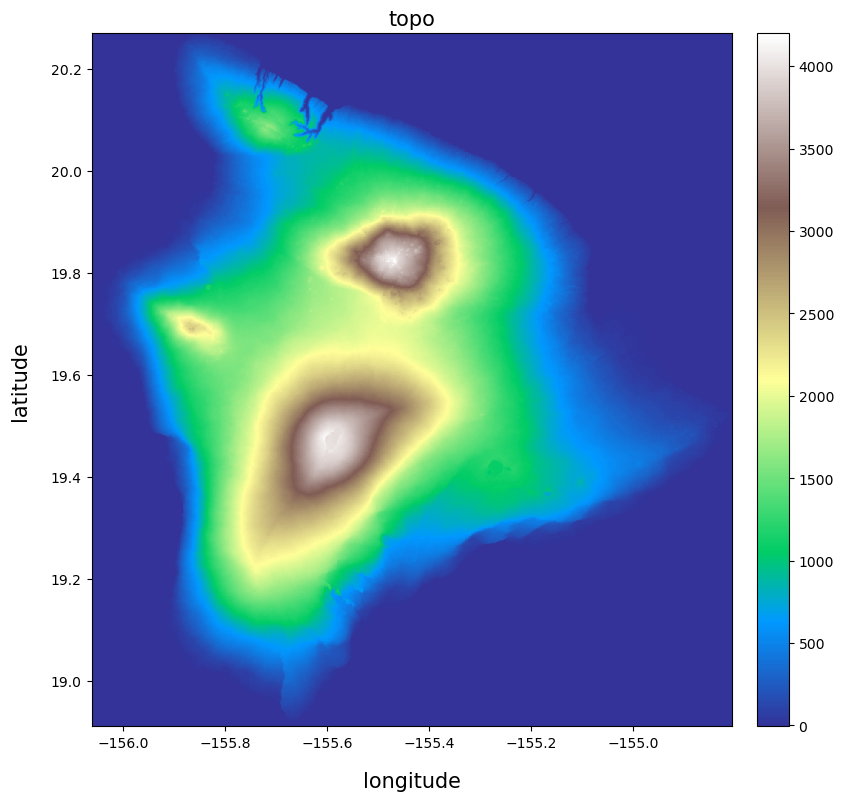

In [31]:
plot_layer('DEM/glo_90.dem',lay_type='topo')

### Example 5. Correction layers
<a id='example_5'></a>

[Back to Example Table of Contents](#example_TOC)

As explained above, ARIA products can come with a optional layers to correct for tropospheric, ionospheric, and solid Earth tidal effects. Here, we demonstrate these corrections and show the effects on an interferogram. Recall that the troposphere and SET layers are provided with sparse lateral sample spacing on fixed height levels to conserve file size.

Each of these correction layers can be extracted using **`ariaExtract.py`**, and plot them. We show the fixed height layers for troposphere and SET phase delays, and the full-resolution ionosphere correction layer.

#### Troposphere correction

In [32]:
!ariaExtract.py -f "products/*.nc" -l troposphereTotal -tm ERA5 -d DEM/glo_90.dem -m mask/esa_world_cover_2021.msk -b {shp} 

/opt/miniconda3/envs/ARIA-tools/bin/ariaExtract.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('ARIAtools==1.1.0')
2024-07-30 12:35:03,482 - ARIAtools.util.dem - WARNING - Cannot proceed with VRT format, using ENVI format instead
2024-07-30 12:35:03,484 - ARIAtools.util.dem - WARNING - The DEM you specified already exists in ./DEM, using the existing one...
Generating: troposphereWet_ERA5 troposphereTotal - [==================================================] 20180502_20180408 


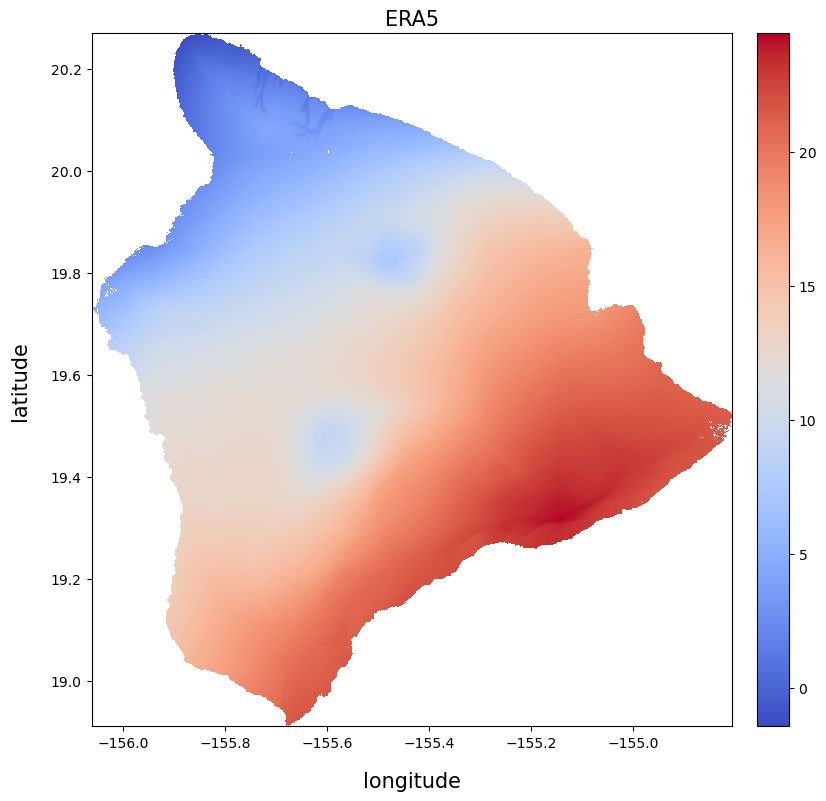

In [33]:
plot_layer('troposphereTotal/ERA5/20180502_20180408.vrt')

#### Solid Earth tide correction

In [34]:
!ariaExtract.py -f "products/*.nc" -l solidEarthTide -d DEM/glo_90.dem -m mask/esa_world_cover_2021.msk -b {shp} 

/opt/miniconda3/envs/ARIA-tools/bin/ariaExtract.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('ARIAtools==1.1.0')
2024-07-30 12:35:32,837 - ARIAtools.util.dem - WARNING - Cannot proceed with VRT format, using ENVI format instead
2024-07-30 12:35:32,839 - ARIAtools.util.dem - WARNING - The DEM you specified already exists in ./DEM, using the existing one...
Generating: solidEarthTide - [==================================================] 20180502_20180408 


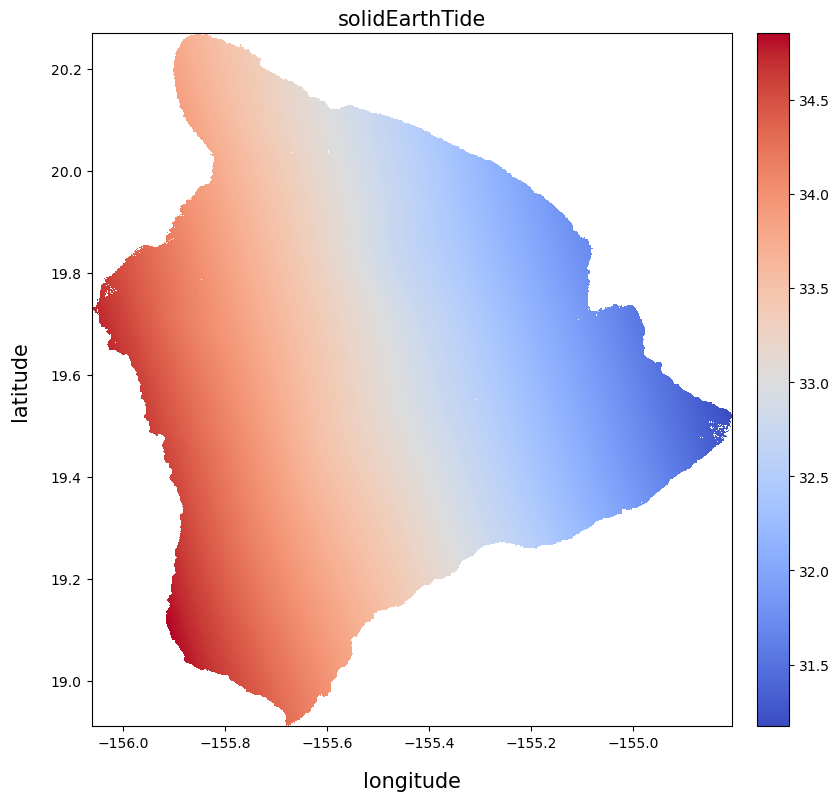

In [35]:
plot_layer('solidEarthTide/20180502_20180408.vrt')

#### Ionosphere correction

In [36]:
!ariaExtract.py -f "products/*.nc" -l ionosphere -m mask/esa_world_cover_2021.msk -b {shp} 

/opt/miniconda3/envs/ARIA-tools/bin/ariaExtract.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('ARIAtools==1.1.0')


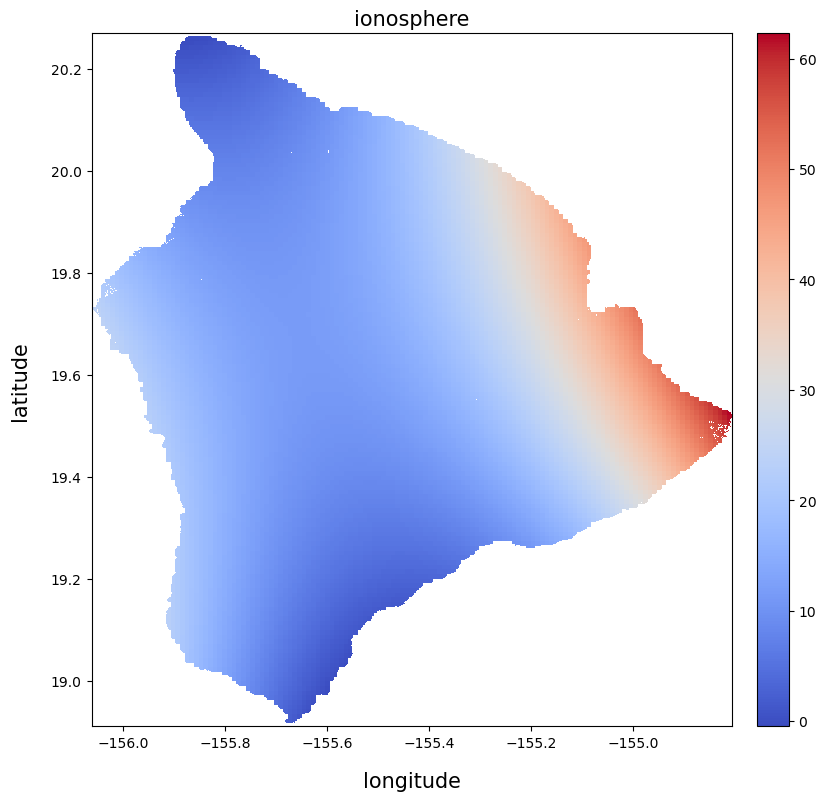

In [37]:
plot_layer('ionosphere/20180502_20180408.vrt')

The correction layers can then be removed from the unwrapped phase.

In [38]:
# first initiate function to access value at specified reference point
import rasterio
from rasterio.warp import transform

def get_ref_value(fname, lon, lat):
    # Open the raster file
    with rasterio.open(fname) as src:
        # Transform WGS84 coordinates to the raster's coordinate reference system (CRS)
        src_crs = src.crs
        wgs84_crs = 'EPSG:4326'
        x, y = transform(wgs84_crs, src_crs, [lon], [lat])

        # Get the pixel values at the transformed coordinates
        row, col = src.index(x[0], y[0])
        value = src.read(1)[row, col]

        return float(value)

In [39]:
!mkdir correctedIFG

# get value at specified coordinates to re-reference all rasters to the same point
unw_val = get_ref_value('unwrappedPhase/20180502_20180408.vrt', -155.34780, 19.28224)
tropo_val = get_ref_value('troposphereTotal/ERA5/20180502_20180408.vrt', -155.34780, 19.28224)
set_val = get_ref_value('solidEarthTide/20180502_20180408.vrt', -155.34780, 19.28224)
iono_val = get_ref_value('ionosphere/20180502_20180408.vrt', -155.34780, 19.28224)

# remove troposphere
!gdal_calc -A unwrappedPhase/20180502_20180408.vrt \
    -B troposphereTotal/ERA5/20180502_20180408.vrt \
    --outfile correctedIFG/unw-tropo \
    --calc='(A-{unw_val}) - (B-{tropo_val})'

# remove solid Earth tide
!gdal_calc -A unwrappedPhase/20180502_20180408.vrt \
    -B troposphereTotal/ERA5/20180502_20180408.vrt \
    -C solidEarthTide/20180502_20180408.vrt \
    --outfile correctedIFG/unw-tropo-SET \
    --calc='(A-{unw_val}) - (B-{tropo_val}) - (C-{set_val})'

# remove ionosphere
!gdal_calc -A unwrappedPhase/20180502_20180408.vrt \
    -B troposphereTotal/ERA5/20180502_20180408.vrt \
    -C solidEarthTide/20180502_20180408.vrt \
    -D ionosphere/20180502_20180408.vrt \
    --outfile correctedIFG/unw-tropo-SET-iono \
    --calc='(A-{unw_val}) - (B-{tropo_val}) - (C-{set_val}) - (D-{iono_val})'

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


/opt/miniconda3/envs/ARIA-tools/lib/python3.12/site-packages/matplotlib/colors.py:732: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
/opt/miniconda3/envs/ARIA-tools/lib/python3.12/site-packages/matplotlib/image.py:513: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / frac)


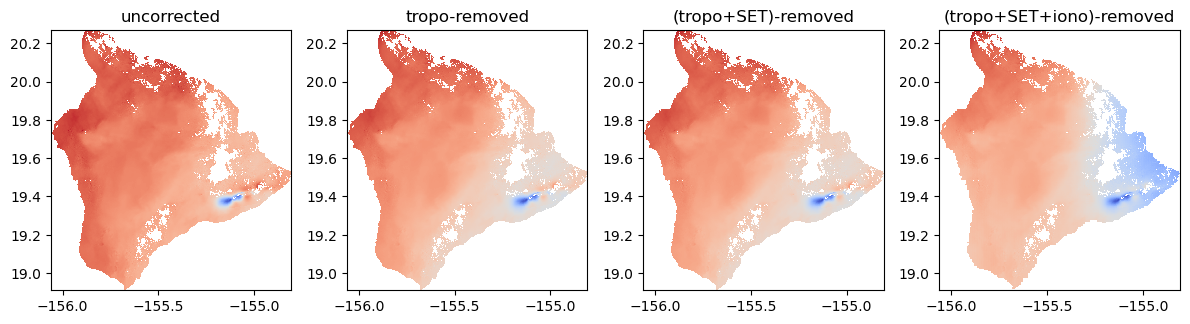

In [40]:
def plot_corrected_unw(path_layer, fig, ax, title):
    """Plot the unwrapped phase with various correction layers subtracted.
    
    Arguments:
        path_layer is a string to the GDAL-compatible dataset to be plotted
        fig, ax are the figure and axis on which to plot the data
    """
    # get the lon lat bounds
    ds       = gdal.Open(path_layer, gdal.GA_ReadOnly)
    trans    = ds.GetGeoTransform()
    extent   = [trans[0], trans[0] + ds.RasterXSize * trans[1], trans[3] + ds.RasterYSize*trans[5], trans[3]]

    # get the data
    raster = ds.GetRasterBand(1)
    NoData = raster.GetNoDataValue()
    arr = raster.ReadAsArray()
    arr = np.ma.masked_where(arr==NoData, arr)
    ds = None
    
    # plot the data
    im = ax.imshow(arr, cmap=plt.cm.coolwarm, extent=extent, interpolation='nearest')

    # format plot
    ax.set_title(title)


fig, axes = plt.subplots(figsize=(12,9), ncols=4)

plot_corrected_unw('unwrappedPhase/20180502_20180408.vrt', fig, axes[0], 'uncorrected')
plot_corrected_unw('correctedIFG/unw-tropo', fig, axes[1], 'tropo-removed')
plot_corrected_unw('correctedIFG/unw-tropo-SET', fig, axes[2], '(tropo+SET)-removed')
plot_corrected_unw('correctedIFG/unw-tropo-SET-iono', fig, axes[3], '(tropo+SET+iono)-removed')

fig.tight_layout()


***Reminder:*** The ionospheric correction is especially difficult to estimate for C-band interferograms, and should be used with caution or excluded from time-series processing.

## Applications <a id='applications'></a>

### Application 1.  ENU conversion factors <a id='application_1'></a>

For geophysical modeling and analysis, it is often useful to know how much displacements in the east, north and up directions contribute to the radar line-of-sight (LOS) displacement. The mathematical equations to convert ARIA GUNW product to ENU are as follows:

\begin{equation}
E = \sin(\theta)\cos(\alpha), \quad N = \sin(\theta)\sin(\alpha), \quad U = \cos(\theta)
\end{equation}

where $\theta$ is the *incidence angle* (wrt vertical) and $\alpha$ is the *azimuth angle* (counterclockwise angle between the East and the look direction from the ground target to the sensor). We will extract these meta-data layers over the main island using a shapefile of the island as the bounding box and provide the instruction for downloading a DEM.

In [41]:
# Remove temp geometry files from previous runs (if they exist)
if os.path.exists('metadatalyr_plots'):
    shutil.rmtree('metadatalyr_plots')
if os.path.exists('incidenceAngle'):
    shutil.rmtree('incidenceAngle')
if os.path.exists('azimuthAngle'):
    shutil.rmtree('azimuthAngle')

In [42]:
!ariaExtract.py -f "products/*.nc" -l "incidenceAngle,azimuthAngle" -d DEM/glo_90.dem -b {shp}

/opt/miniconda3/envs/ARIA-tools/bin/ariaExtract.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('ARIAtools==1.1.0')
2024-07-30 12:46:58,272 - ARIAtools.util.dem - WARNING - Cannot proceed with VRT format, using ENVI format instead
2024-07-30 12:46:58,279 - ARIAtools.util.dem - WARNING - The DEM you specified already exists in ./DEM, using the existing one...


Next, we will use GDAL to load both the *incidence* and *azimuth angles* into python, use **`numpy`** functionality to calculate the east, north and up conversions factors using the equations provided above, and lastly leverage GDAL for writing out the 3-band *enu* file to the *results* folder.

In [43]:
import glob

## setup the paths for the calculation
if not os.path.exists('results'):
    os.mkdir('results')
ifg      = '20180502_20180408'
path_src = [os.path.join(layer, ifg) for layer in ['incidenceAngle', 'azimuthAngle']]
path_dst = os.path.join('results', '{}_enu'.format(ifg))
    
# removing files
for file in glob.glob(path_dst + '*'):
    os.remove(file)

## loading the data
ds       = gdal.Open(path_src[0], gdal.GA_ReadOnly)
raster = ds.GetRasterBand(1)
try:
    NoData = raster.GetNoDataValue()
except:
    NoData = None
arr_inc  = raster.ReadAsArray()
arr_azi  = gdal.Open(path_src[1], gdal.GA_ReadOnly).ReadAsArray()
NoData_mask = (arr_inc==NoData)
NoData_out = 0


## convert to radians and calculate
arr_incd = np.deg2rad(arr_inc)
arr_azid = np.deg2rad(arr_azi)
#E = np.sin(arr_incd) * np.cos(arr_azid + np.pi/2)
#N = np.sin(arr_incd) * np.sin(arr_azid + np.pi/2)
E = np.sin(arr_incd) * np.cos(arr_azid)
N = np.sin(arr_incd) * np.sin(arr_azid )
U = np.cos(arr_incd)
E[NoData_mask]=NoData_out
N[NoData_mask]=NoData_out
U[NoData_mask]=NoData_out


## copy the projection information into a memory; most formats dont support adding bands
ds_out = gdal.GetDriverByName('MEM').CreateCopy('', ds)

## write ENU to separate bands
description = ['East to LOS','North to LOS','Up to LOS']
for i, j in enumerate([E, N, U]):
    try:
        band = ds_out.GetRasterBand(i+1)
    except:
        # add a float 32 band when it doesn't exist
        ds_out.AddBand(gdal.GDT_Float32)
        band = ds_out.GetRasterBand(i+1)

    j = np.where(np.isnan(j), NoData_out, j)
    band.SetNoDataValue(NoData_out)
    band.WriteArray(j)
    band.SetDescription(description[i])


## write dataset to disk and build a VRT for it
ds = gdal.Translate(path_dst, ds_out, noData=NoData_out, format='ENVI')
gdal.BuildVRT('{}.vrt'.format(path_dst), ds)
del ds, ds_out

In [44]:
ls results/20180502_20180408_enu*

results/20180502_20180408_enu          results/20180502_20180408_enu.hdr
results/20180502_20180408_enu.aux.xml  results/20180502_20180408_enu.vrt


Can you rank the *ENU* conversion magnitude to the Line-of-Sight from large to small?
We will use **`gdalinfo`**` -stats` to verify the mean conversion factors.

In [45]:
!gdalinfo results/20180502_20180408_enu.vrt -stats

Driver: VRT/Virtual Raster
Files: results/20180502_20180408_enu.vrt
       results/20180502_20180408_enu
Size is 1507, 1631
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-156.062437574998995,20.269158559000001)
Pixel Size = (0.000833333000000,-0.000833333000000)
Corner Coordinates:
Upper Left  (-156.0624376,  20.2691586) (156d 3'44.78"W, 20d16' 8.97"N)
Lower Left  (-156.0624376,  18.9099924) (156d 3'44.78"W, 18d54'35.97"N)
Upper Right (-154.8066047,  20.2691586) (154d4

Let's now take a look at the resulting E, N, U rasters

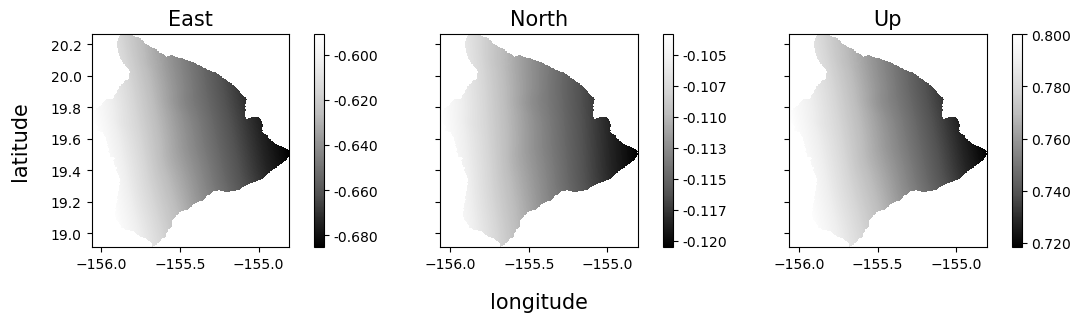

In [46]:
## setup the paths for the calculation
ifg      = '20180502_20180408'
path_src = os.path.join('results', '{}_enu'.format(ifg))
plot_layer(path_src, 'ENU')

### Application 2. Computing displacement map <a id='application_2'></a>

The unwrapped interferogram is provided in radian units, with positive radians corresponding to uplift. The conversion from interferometric phase, $\varphi$, to line‐of‐sight displacement, $d$, with uplift being positive is controlled by $\lambda/4\pi$  conversion factor as:

$$ d = \frac{\lambda}{4\pi}   \varphi, $$
   
with $\lambda$ the radar wavelength. Note that no minus sign is included to do the phase sign convention of the GUNW product being positive for uplift. The wavelength is stored within each GUNW product and can be retrieved using the netcdf reader (see  code snippet below for an example), however for simplicity we directly fix it to 5.54 cm.

```
fname='products/S1-GUNW-A-R-124-tops-20180502_20180408-043040-20161N_18088N-PP-6704-v2_0_1.nc'
rdrmetadata = netCDF4.Dataset(fname, keepweakref=True, diskless=True).groups['science'].groups['radarMetaData']
rdrmetadata['wavelength'].getValue()
```

We extract the unwrapped phase using a shapefile over the main island of Hawaii.

In [47]:
if not os.path.exists('results'):
    os.mkdir('results')
!ariaExtract.py -f "products/*.nc" -l unwrappedPhase --bbox {shp}

/opt/miniconda3/envs/ARIA-tools/bin/ariaExtract.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('ARIAtools==1.1.0')


Next, we leverage the command line **`gdal_calc.py`** program to calculate the corresponding displacement map in cm by scaling the unwrapped interferogram. The connected component 0s are utilized as a mask. Outputs are written to the *results* folder with *defo* filenames, and visualized with our plotting function.

0...10...20...30...40...50...60...70...80...90...100 - done.


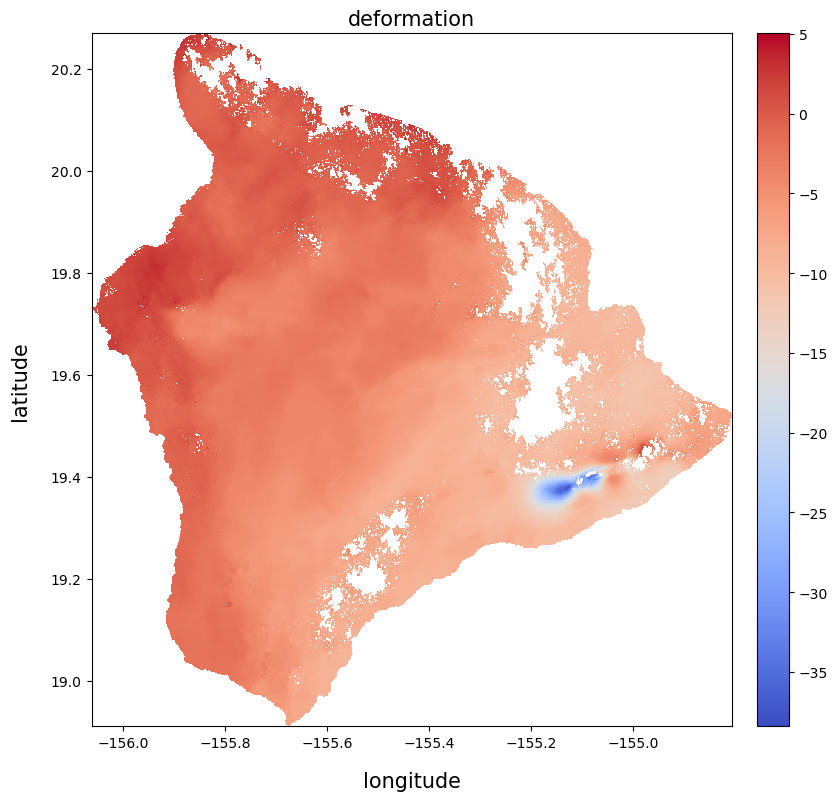

In [48]:
## use gdal_calc.py to perform the calculation
!gdal_calc.py -A unwrappedPhase/20180502_20180408.vrt -B connectedComponents/20180502_20180408.vrt --outfile results/20180502_20180408_defo --calc='((A*(B>0))/(4*pi)*5.546576)' --format=ENVI --NoDataValue=0 --overwrite

## view the plot
plot_layer('results/20180502_20180408_defo', 'deformation')

The blue area represents ground subsidence due to magma withdrawal from Kilauea’s Middle East Rift Zone due to magma moving to the east (down-rift). The actual dike signature would be partially visible if the image were shown as wrapped phase.

<a id='application3'></a>

### Application 3. Converting geoJSON to ESRI shapefile 


You can easily convert geospatial files produced by ariaTools to other formats using the [ogr2ogr program](https://gdal.org/programs/ogr2ogr.html) (part of the GDAL source tree). For example, to convert the `productBoundingBox.json` to an ESRI shapefile:

In [49]:
!ogr2ogr -f "ESRI Shapefile" ./productBoundingBox/productBoundingBox.shp ./productBoundingBox/productBoundingBox.json

In [50]:
!ls ./productBoundingBox

20180502_20180408.json
productBoundingBox.dbf
productBoundingBox.json
productBoundingBox.prj
productBoundingBox.shp
productBoundingBox.shx
productBoundingBox_croptounion_formetadatalyr.json
